In [1]:
from PIL import Image, ImageDraw
import numpy as np
from IPython.display import HTML

In [2]:
S = 8
width = 28
height = 22

color = (64,64,64, 255)
fill_color = (255, 204, 64)

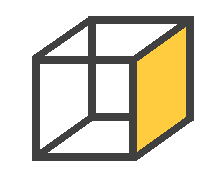

In [3]:
test_color = None 
# test_color = (255,0,0, 50)

def c(xy):
    return (xy[0]*S, (height-xy[1])*S)

def d(xy, Sd):
    return (xy[0]*S + Sd, (height-xy[1])*S + Sd)

def add(x,y):
    return (x[0]+y[0], x[1]+y[1])

def cube(face):
    im = Image.new("RGBA", (width*S, height*S), color=test_color)

    draw = ImageDraw.Draw(im)
    r = 13
    dx = 7
    dy = 5
    f00 = (4,2)
    f01 = add(f00, (0,r))
    f10 = add(f00, (r,0))
    f11 = add(f00, (r,r))
    b00 = add(f00, (dx, dy))
    b01 = add(b00, (0,r))
    b10 = add(b00, (r,0))
    b11 = add(b00, (r,r))

        
    if face == "rear":
        draw.polygon((c(b00), c(b10), c(b11), c(b01)), fill=fill_color, outline=fill_color)
    
    draw.rectangle((c(b00), c(b11)), fill=None, width=S, outline=color)

    if face == "bottom":
        draw.polygon((c(f00), c(f10), c(b10), c(b00)), fill=fill_color, outline=fill_color)
    if face == "top":
        draw.polygon((c(f01), c(f11), c(b11), c(b01)), fill=fill_color, outline=fill_color)
    if face == "right":
        draw.polygon((c(f00), c(b00), c(b01), c(f01)), fill=fill_color, outline=fill_color)
    if face == "left":
        draw.polygon((c(f10), c(b10), c(b11), c(f11)), fill=fill_color, outline=fill_color)

    draw.line((add(c(f00),(2,-3)),  add(c(b00), (2,-3))),  width=S, fill=color)
    draw.line((add(c(f01),(3,1)),   add(c(b01), (3,2))),   width=S, fill=(color))
    draw.line((add(c(f10),(-2,-3)), add(c(b10), (-2,-3))), width=S, fill=color)
    draw.line((add(c(f11),(-3,3)),  add(c(b11), (-3,3))),  width=S, fill=color)
    draw.line((add(c(b01),(0,3)),   add(c(b11), (0,3))),   width=S, fill=color)
    draw.line((add(c(b10),(-2,0)),  add(c(b11), (-2,0))),  width=S, fill=color)
    
    if face == "front":
        draw.polygon((c(f00), c(f10), c(f11), c(f01)), fill=fill_color, outline=fill_color)
    draw.rectangle((c(f00), c(f11)), fill=None, width=S, outline=color)
    
    return im

for face in ["edges", "front", "rear", "bottom", "top", "right", "left"]:
    im = cube(face)
    im.save("./icons/%s.png" % face)
im

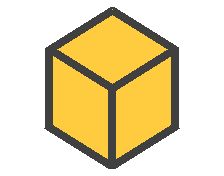

In [4]:
import math

def isom():
    im = Image.new("RGBA", (width*S, height*S), color=test_color)

    draw = ImageDraw.Draw(im)
 
    x0 = 6
    r = 10
    dy = r/2
    dx = int(r*math.cos(math.pi/6))

    f00 = (x0, 1+dy)
    f01 = add(f00, (0,r))
    f10 = (x0+dx, 1)
    f11 = add(f10, (0,r))
    f12 = add(f11, (0,r))
    f20 = add(f00,(2*dx,0))
    f21 = add(f20, (0,r))
    draw.line((add(c(f10), (0,0)), add(c(f12), (0,-1))), width=4, fill=color)
    draw.polygon((c(f00), c(f01), c(f11), c(f10)), fill=fill_color, outline=color)
    draw.polygon((c(f10), c(f11), c(f21), c(f20)), fill=fill_color, outline=color)
    draw.polygon((c(f01), c(f11), c(f21), c(f12)), fill=fill_color, outline=color)
    draw.line((add(c(f00), (-2,-3)), add(c(f10), (-2,-3))), width=S, fill=color)
    draw.line((add(c(f10), (1,-3)), add(c(f20), (1,-3))), width=S, fill=color)
    draw.line((add(c(f01), (0,0)), add(c(f11), (0,0))), width=S, fill=color)
    draw.line((add(c(f11), (0,0)), add(c(f21), (0,0))), width=S, fill=color)
    draw.line((add(c(f01), (0,2)), add(c(f12), (0,2))), width=S, fill=color)
    draw.line((add(c(f12), (0,2)), add(c(f21), (0,2))), width=S, fill=color)
    draw.line((add(c(f00), (1,0)), add(c(f01), (1,0))), width=S, fill=color)
    draw.line((add(c(f10), (0,0)), add(c(f11), (0,0))), width=S, fill=color)
    draw.line((add(c(f20), (-1,0)), add(c(f21), (-1,0))), width=S, fill=color)
    
    return im
im = isom()
im.save("./icons/isometric.png")
im

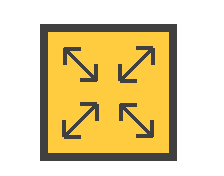

In [5]:
def fit():
    im = Image.new("RGBA", (width*S, height*S), color=test_color)

    draw = ImageDraw.Draw(im)

    S2 = 4
    P = 2
    l = 4
    x0 = 8
    y0 = 5
    
    b00 = (x0-3, y0-3)
    b11 = (width-6, height-3)
    
    f00 = (x0, y0)
    g00 = add(f00, (l,l))

    f01 = (x0, height-y0-1)
    g01 = add(f01, (l,-l))

    f10 = (width - x0-1, y0)
    g10 = add(f10, (-l,l))
    
    f11 = (width - x0-1, height-y0-1)
    g11 = add(f11, (-l,-l))
    
    draw.rectangle((c(b00), c(b11)), fill=fill_color, width=S, outline=color)
    
    draw.line((c(f00), c(g00)), width=S2, fill=color)
    draw.line((c(f01), c(g01)), width=S2, fill=color)
    draw.line((c(f10), c(g10)), width=S2, fill=color)
    draw.line((c(f11), c(g11)), width=S2, fill=color)

    draw.line((c(f00), c(add(f00, (0, P)))), width=S2, fill=color)
    draw.line((c(f00), c(add(f00, (P, 0)))), width=S2, fill=color)
    draw.line((c(g00), c(add(g00, (0, -P)))), width=S2, fill=color)
    draw.line((c(g00), c(add(g00, (-P, 0)))), width=S2, fill=color)
    
    draw.line((c(f01), c(add(f01, (0, -P)))), width=S2, fill=color)
    draw.line((c(f01), c(add(f01, (P, 0)))), width=S2, fill=color)
    draw.line((c(g01), c(add(g01, (0, P)))), width=S2, fill=color)
    draw.line((c(g01), c(add(g01, (-P, 0)))), width=S2, fill=color)
    
    draw.line((c(f10), c(add(f10, (0, P)))), width=S2, fill=color)
    draw.line((c(f10), c(add(f10, (-P, 0)))), width=S2, fill=color)
    draw.line((c(g10), c(add(g10, (0, -P)))), width=S2, fill=color)
    draw.line((c(g10), c(add(g10, (P, 0)))), width=S2, fill=color)
    
    draw.line((c(f11), c(add(f11, (0, -P)))), width=S2, fill=color)
    draw.line((c(f11), c(add(f11, (-P, 0)))), width=S2, fill=color)
    draw.line((c(g11), c(add(g11, (0, P)))), width=S2, fill=color)
    draw.line((c(g11), c(add(g11, (P, 0)))), width=S2, fill=color)
    
    return im

im = fit()
im.save("icons/fit.png")
im

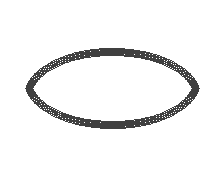

In [11]:
import math

test_color = None 
#test_color = (255,0,0, 50)

def visible(visible=True):
    im = Image.new("RGBA", (width*S, height*S), color=test_color)

    P = 8
    R = 5
    b00 = (3, height - 5)
    b11 = (width - 3, 5)
    c00 = (width // 2 - R, height // 2 + R)
    c11 = (width // 2 + R, height // 2 - R)
    p00 = (width // 2 - 2, height // 2 + 2)
    p11 = (width // 2 + 2, height // 2 - 2)

    draw = ImageDraw.Draw(im)
    draw.arc((add(c(b00), (0,P)), add(c(b11), (0,P))), start=-170, end=-10, width=S, fill=color)
    draw.arc((add(c(b00), (0,-P)), add(c(b11), (0,-P))), start=10, end=170, width=S, fill=color)
    if visible:
        draw.ellipse((*c(c00), *c(c11)), width=S, outline=color, fill=fill_color)
        draw.ellipse((*c(p00), *c(p11)), width=S, outline=color, fill=color)
    return im

im = visible(False)
im.save("icons/visible.png")
im

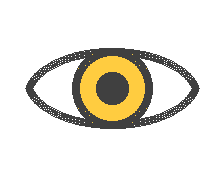

In [12]:
im = visible(True)
im.save("icons/hidden.png")
im

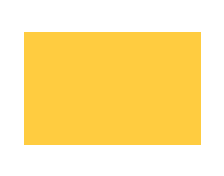

In [10]:
import math

test_color = None 
#test_color = (255,0,0, 50)

def mesh(mesh=True):
    im = Image.new("RGBA", (width*S, height*S), color=test_color)
    draw = ImageDraw.Draw(im)
    
    f00 = (3, 4)
    f01 = (3, height-4)
    f10 = (width-3, 4)
    f11 = (width-3, height-4) 
    
    if mesh:
        draw.rectangle((c(f00), c(f11)), fill=fill_color, width=S, outline=color)
        draw.line((c(add(f00, (0,5))), c(add(f10, (0,5)))), width=S, fill=color)
        draw.line((c(add(f00, (0,9))), c(add(f10, (0,9)))), width=S, fill=color)
        draw.line((c(add(f00, (11,0))), c(add(f01, (11,0)))), width=S, fill=color)
    else:
        draw.rectangle((c(f00), c(f11)), fill=fill_color, width=S, outline=None)

    return im

im = mesh(False)
im.save("icons/no_mesh.png")
im

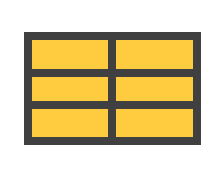

In [9]:
im = mesh(True)
im.save("icons/mesh.png")
im

In [5]:
color = (255,100,0)
"#%02s%02s%02s" % [hex(c)[2:] for c in color]

TypeError: not enough arguments for format string

In [6]:
[hex(c)[2:] for c in color]

['ff', '64', '0']

In [11]:
"#%02x%02x%02x" % color

'#ff6400'

In [12]:
tuple(color)

(255, 100, 0)

In [13]:
tuple(['ff', '64', '0'])

('ff', '64', '0')